# Continuous Wave

In [41]:
from __future__ import division
import tqdm
import sys
sys.path.append('/home/jianwei_leejw/scripts/TESPulseFitCode')
# sys.path.append('/workspace/projects/TES/scripts')
import heralded_pulses_analysis as hpa
import numpy as np
import matplotlib
# matplotlib.use('nbAgg')
%matplotlib inline
import matplotlib.pyplot as plt
import glob
from lmfit import Model, Parameters
import pymc
import seaborn
from scipy.stats import norm
from scipy.signal import savgol_filter
from scipy.fftpack import fft, rfft, fftshift
import pickle

import pulse_fit_v05 as pf
import single_photon_model_no_shift as noshift
import pulse_averaging as pa
import thres_poiss
import pulse_discrimination as pd
import stats_proc as sp

# Single Photon Model

### Step 1a) Calculate Height Thresholds or...

In [5]:
# Imports single diode excitation traces
directory_name = '/mnt/disks/disk1/data/20170523_TES5_75mK_95uA_trise_115ns/singles/'
results_directory = './'
filelist = np.array(glob.glob(directory_name + '*.trc'))
filelist = np.flipud(np.sort(filelist))
print(filelist[0:2])
print len(filelist)

[ '/mnt/disks/disk1/data/20170523_TES5_75mK_95uA_trise_115ns/singles/C2single20129.trc'
 '/mnt/disks/disk1/data/20170523_TES5_75mK_95uA_trise_115ns/singles/C2single20128.trc']
20130


In [3]:
# Set left and right time limits of each trace to process
t_initial = None
t_final = None
height_th = 0.01 #to be updated with pt of minimal overlap between n=0 and n=1 distributions
t0 = 0.5e-6

<IPython.core.display.Javascript object>


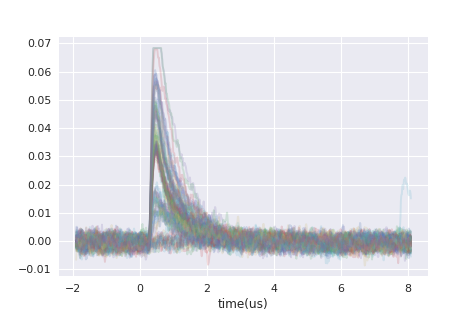

In [4]:
# Performs an initial plot
%matplotlib notebook
reload(hpa)
hpa.pplot(filelist[:1000], height_th, t_initial, t_final)
# plt.xlim(0.2,0.8)
# plt.plot(time_f*1e6+0.3,2*signal_f)

In [6]:
# Extract trace properties, generate height histogram
reload(hpa)
data = np.array([hpa.param_extr(f,t_initial,t_final,height_th,t0)
                 for f
                 in tqdm.tqdm(filelist[:10000])])

100%|██████████| 10000/10000 [01:22<00:00, 121.65it/s]


<IPython.core.display.Javascript object>


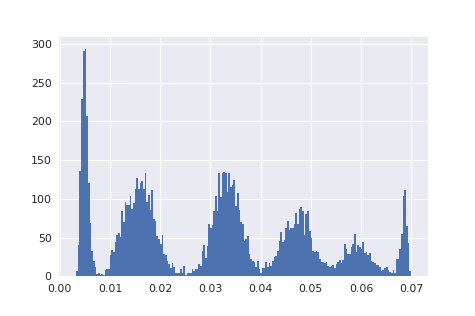

In [7]:
heights = data['height']
pnr_height = np.histogram(heights, 200)
np.savetxt(results_directory+'heights_single_diode_pulse.dat', heights)
%matplotlib notebook
plt.figure()
plt.hist(heights,200);

<IPython.core.display.Javascript object>


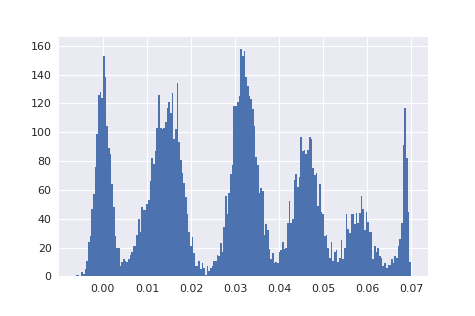

In [8]:
heightsattime = data['heightattime']
np.savetxt(results_directory+'heightsattime_{}_single_diode_pulse.dat'.format(t0), heights)
%matplotlib notebook
plt.figure()
plt.hist(heightsattime,200);

In [60]:
# Detect valleys separating peaks or...
th = thres_poiss.thresholds_N(pnr_height, min_peak_sep=0.01, weighted=True)
np.savetxt(results_directory+'height_thresholds_single_diode_pulse.dat',th)
print th

[(0.0071492986173833772, 0.0012487224351785209, 0.00023495423772657009), (0.024636946328982976, 0.0013450109795819516, 0.0013186834539321568), (0.040437462296290472, 0.0072839356322711296, 0.0071857168201068244), (0.059302944959656781, 2.5082697655063106e-05, 2.4224983543374989e-05)]


### Step 1b) or.. load threshold file if exists

In [10]:
th = np.loadtxt(results_directory+'height_thresholds_single_diode_pulse.dat')
print th

[[ 0.00716969  0.00107478  0.0002068 ]
 [ 0.02459256  0.00103776  0.00101646]
 [ 0.04030009  0.00686803  0.00677397]
 [ 0.05316497  0.01856983  0.01876015]
 [ 0.06430023  0.03196324  0.03222985]]


[ 0.0195912   0.0457056   0.0296028  ...,  0.0319032   0.052488    0.05914081]


<IPython.core.display.Javascript object>


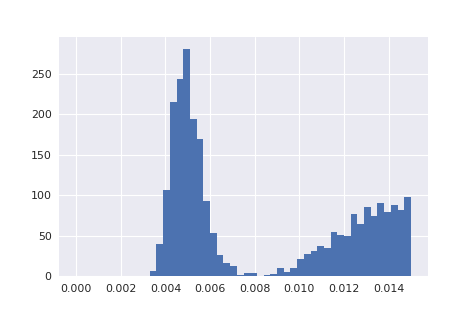

In [63]:
heights = np.loadtxt(results_directory+'heights_single_diode_pulse.dat')
print heights
%matplotlib notebook
plt.figure()
plt.hist(heights,50,range=(0,0.015));

In [13]:
# Noise Amplitude Standard Deviation
(mu0,sigma0) = norm.fit(heights[(heights<th[0][0])])
print mu0, sigma0, sigma0/mu0

0.00498539279183 0.000663714733303 0.133131883688


In [14]:
# Single Photon Amplitude Standard Deviation
(mu,sigma) = norm.fit(heights[(heights>th[0][0])&(heights<th[1][0])])
print mu, sigma, sigma/mu

0.0158423826017 0.00301191019319 0.190117248707


In [15]:
# Update height threshold, ,reprocess trace parameters
height_th = th[0][0]
print height_th

0.00716969023503


In [16]:
th[0][0]/mu, th[1][0]/mu, (1-0.6)/(sigma/mu)

(0.45256388608309184, 1.5523268074596248, 2.1039648044613237)

### Step 2a) Calculate Single Photon Model or...

In [17]:
reload(hpa)
data = np.array([hpa.param_extr(f,t_initial,t_final,h_th=height_th)
                 for f
                 in tqdm.tqdm(filelist[:10000])])

100%|██████████| 10000/10000 [01:30<00:00, 110.53it/s]


In [18]:
# Generate Height and Area histograms
heights = data['height']
areas = data['area_win']

# use the area to count the number of photons
pnr_height = np.histogram(heights, 200)
pnr = np.histogram(areas, 200)

# remove the first bin that is not gaussian, and will affect the threshold detection algorithm

pnr = [pnr[0][1:], pnr[1][1:]]

<IPython.core.display.Javascript object>


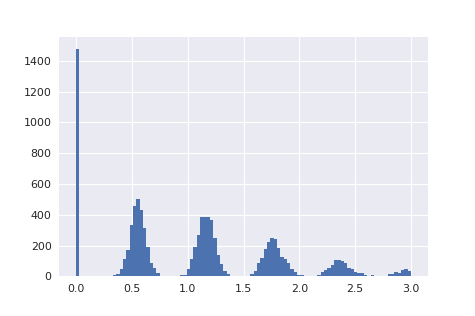

In [19]:
# Plot area histogram to survey area distinguishibility
# First bin will still be visible
plt.figure()
plt.hist(areas,100,
         range=(0,3)
        );

In [20]:
# Detect valleys separating peaks (for area distribution) or...
th_areas = thres_poiss.thresholds_N(pnr, min_peak_sep=0.3, weighted=True)
np.savetxt(results_directory+'area_thresholds_single_diode_pulse.dat',th_areas)
print th_areas

[(0.83820528916122572, 1.7837214343017875e-05, 1.5006394158967318e-05), (1.4659133115579388, 7.3819994294383799e-05, 7.6111117607191581e-05), (2.0640262134601706, 9.009690834200876e-05, 8.7440765538460141e-05), (2.6646479211637439, 6.1054089332430764e-05, 6.2994271922578449e-05)]


In [ ]:
# or.. load area threshold file if exists

In [21]:
th_areas = np.loadtxt(results_directory+'area_thresholds_single_diode_pulse.dat')
print th_areas

[[  8.38205289e-01   1.78372143e-05   1.50063942e-05]
 [  1.46591331e+00   7.38199943e-05   7.61111176e-05]
 [  2.06402621e+00   9.00969083e-05   8.74407655e-05]
 [  2.66464792e+00   6.10540893e-05   6.29942719e-05]]


0


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:4: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 20130 but corresponding boolean dimension is 10000
  after removing the cwd from sys.path.


<IPython.core.display.Javascript object>


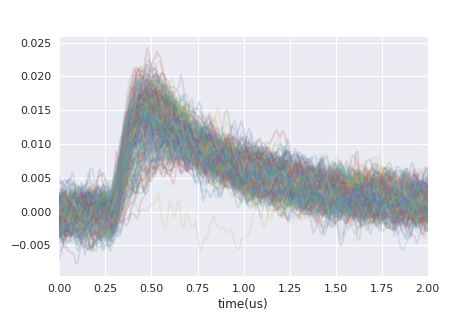

In [28]:
mask_1ph = (areas>pnr[1][1])&(areas<th_areas[0][0])
np.savetxt(results_directory+'mask_1ph_cont.dat', mask_1ph)
# reload(hpa)
hpa.pplot(filelist[mask_1ph], height_th)
plt.xlim(0,2);

In [25]:
# Generate average pulse without horizontal offset correction
reload(pa)
time_p, signal_p = pa.trace_ave(filelist[:10000][mask_1ph], t_initial, t_final)

# Use average pulse to generate single photon model
def one_pulse(x, x_offset=0, amplitude=1):
    """convert the sample single photon pulse into a function
    that can be used in a fit
    """
    x = x - x_offset
    return amplitude * np.interp(x, time_p, signal_p)

fit_model = Model(one_pulse)

In [26]:
# Use model to generate another model that has horizontal offset correction
reload(pa)
time_f, signal_f, sigma_f = pa.fit_corrected_pulse(filelist[:10000][mask_1ph], 
                                                   fit_model,
                                                   t_initial,
                                                   t_final)
print('done!')

done!


<IPython.core.display.Javascript object>


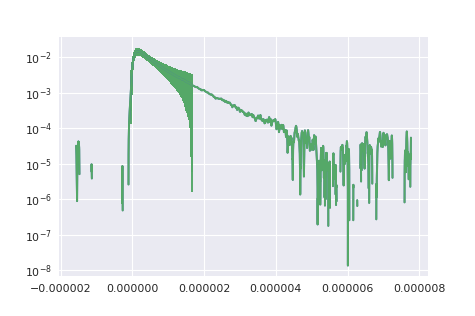

[]

In [29]:
# plots single photon model in semilog axis to check vertical offset correction 
plt.figure()
plt.plot(time_f,signal_f)
plt.semilogy()

<IPython.core.display.Javascript object>


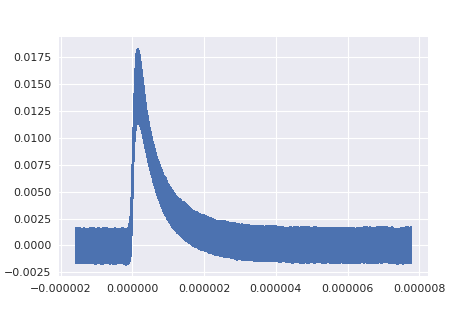

<Container object of 3 artists>

In [31]:
plt.figure()
plt.errorbar(time_f, signal_f, yerr=sigma_f)

In [32]:
np.save(results_directory + 'ph1_model.npy',
            np.array(zip(time_f, signal_f, sigma_f)))

### Step 2b) or... Load Single Photon Model

(-1e-07, 6e-07)

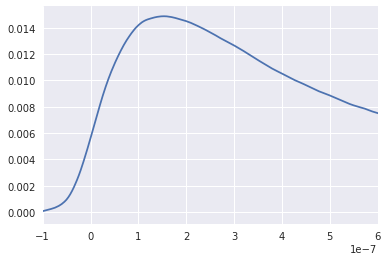

In [33]:
# Loads Single Photon Model
%matplotlib inline
ph1_model = np.load(results_directory + 'ph1_model.npy')
plt.figure()
time_f, signal_f = ph1_model[:,0], ph1_model[:,1]
time_f, signal_f = time_f[:-100], signal_f[:-100]
plt.plot(time_f,signal_f)
plt.xlim(-100e-9,600e-9)

In [34]:
def rise_time(time,signal,plot=True):
    """returns 10% to 90% rise timing"""
    amplitude = np.max(signal)
    idxpeak = np.argmax(signal)
    def find_idx(array,value):
        array=np.array(array)
        return np.argmin(np.abs(array-value))
    t10 = time[find_idx(signal[:idxpeak],0.1*amplitude)]
    t90 = time[find_idx(signal[:idxpeak],0.9*amplitude)]
    risetime = t90-t10
    if plot:
        plt.figure()
        plt.plot(time,signal)
        plt.axvline(t10,linestyle='--')
        plt.axvline(t90,linestyle='--')
    return risetime

121.99999655


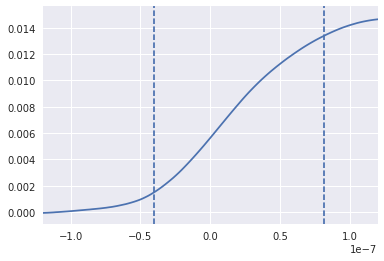

In [35]:
print rise_time(time_f,signal_f)*1e9
plt.xlim(-120e-9,120e-9);

width at height_th = 2.1319999397us


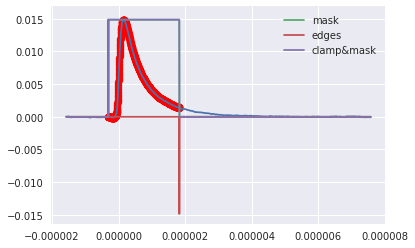

In [36]:
# "Width" of average single photon pulse: 
# Use this to determine the average trace length = 10 us - width
[mask, clamp, edges, left_edges, right_edges] = pd.discriminator(time_f, signal_f, dt_left=200e-9,dt_right=1200e-9, height_th=height_th, Plot=True, method=2)
print('width at height_th = {}us'
    .format(1e6*(time_f[right_edges[0]]-time_f[left_edges[0]])))

### Optional Diagnostics: Single Photon trace Jitter

In [37]:
# fits the model back to the single photon pulse set to obtain jitter for single photon pulses
def fit_one(time,signal,height_th, time_model, signal_model):
    def one_pulse(x, x_offset=0, amplitude=1):
        """convert the sample single photon pulse into a function
        that can be used in a fit
        """
        x = x - x_offset
        return amplitude * np.interp(x, time_model, signal_model)
    p = Parameters()
    p.add('x_offset', time[hpa.find_idx(signal[:np.argmax(signal)],height_th)], vary=1)
    p.add('amplitude', 1, vary=1)
    result = Model(one_pulse).fit(signal, x=time, params=p)
    return result


In [38]:
results = []
for f in tqdm.tqdm(filelist[mask_1ph]):
    time, signal = hpa.trace_extr(f,h_th=height_th)
    try:
        result = fit_one(time, signal,
        height_th=height_th,
        time_model=time_f,
        signal_model=signal_f)
        results.append(result)
    except:
        pass # some traces were empty for some unknown reason...

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 20130 but corresponding boolean dimension is 10000
  
100%|██████████| 2772/2772 [00:29<00:00, 93.00it/s] 


In [39]:
# Extract Offsets
offsets=[r.best_values['x_offset'] for r in results]
np.savetxt(results_directory+'single_photon_arrival_times.dat',offsets)

313.6 348.0


34.399999999999977

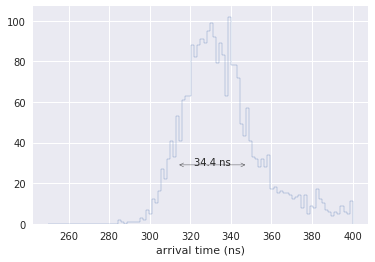

In [40]:
# Plot arrival time distribution
plt.figure()
plt.hist(np.array(offsets)*1e9, 
         bins=100, 
         range = [250,400], 
#          alpha=0.5, 
#          label='without shift', 
         histtype='step', 
#          linestyle='-'
        )
plt.xlabel('arrival time (ns)')
# Compute Jitter for single photon pulse
t_hist = np.histogram(np.array(offsets)*1e9, bins=100, range=[270,350])
reload(noshift)
noshift.FWHM(t_hist[1]+np.diff(t_hist[1])[0]/2, t_hist[0]) 

# Optimal Filter
test phase: functions to be exported to .py in future

In [ ]:
# Step 1: Create Spectral Probability Density Function from Noise Spectrum
# Step 1a: Create discrete spectral probability distribution
def bg_fft(bg_filelist,height_th,numfiles=1000):
    """
    imports files from filelist containing background traces
    traces may have stray photons: these are removed by detecting traces with max smaller than height_th
    """
    for f in tqdm.tqdm(bg_filelist[:numfiles]):
        t, s = hpa.trace_extr(f)
        if np.max(s) < height_th:
            freq, prob = FFT(t, s)
            probs.append(prob)
    probs_mean=np.nanmean(probs,axis=0)
    freq,_ = FFT(*hpa.trace_extr(bg_filelist[0]))
    return freq, probs_mean
# Step 1b: Create continuous spectral probability density function


# Fit to 2 photon traces
typically, we want to run over several folders, but as a start, we'll manually search and replace the folder names and variables corresponding to each folder.

### Step 3: Import 2 diode pulse traces

In [42]:
# Imports double diode excitation traces
directory_name_cont = '/mnt/disks/disk1/data/20170523_TES5_75mK_95uA_trise_115ns/doubles/'
results_directory = './'
filelist_cont = np.array(glob.glob(directory_name_cont + '*.trc'))
filelist_cont = (np.sort(filelist_cont))
print(filelist_cont[:2])
len(filelist_cont)

[ '/mnt/disks/disk1/data/20170523_TES5_75mK_95uA_trise_115ns/doubles/C2doubles00000.trc'
 '/mnt/disks/disk1/data/20170523_TES5_75mK_95uA_trise_115ns/doubles/C2doubles00001.trc']


100000

In [43]:
reload(hpa)
data_cont = np.array([hpa.param_extr(f, t_initial, t_final, h_th=height_th)
                 for f
                 in tqdm.tqdm(filelist_cont)])

100%|██████████| 100000/100000 [05:38<00:00, 295.58it/s]


In [44]:
# Generate Area histograms
areas_cont = data_cont['area_win']

# use the area to count the number of photons
pnr_cont = np.histogram(areas_cont, 200)

# remove the first bin that is not gaussian, and will affect the threshold detection algorithm

pnr_cont = [pnr_cont[0][1:], pnr_cont[1][1:]]

(0, 800)

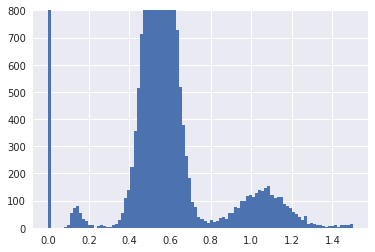

In [45]:
%matplotlib inline
plt.figure()
plt.hist(areas_cont,100,
         range=(0,1.5)
        );
plt.ylim(0,800)

In [46]:
n2 = np.sum([(areas_cont>0.8)&(areas_cont<1.4)])
n1 = np.sum([(areas_cont>0.2)&(areas_cont<0.8)])
n0 = np.sum([(areas_cont<0.2)])
N = len(areas_cont)
print n0,n1,n2,N
np.savetxt('number_distribution.dat',np.array([n0,n1,n2])/N,header='p0\tp1\tp2')

77138 19952 2681 100000


In [47]:
plt.savefig(results_directory+'area_windowed_dtleft_200ns_dtright_700ns.pdf')

### Step 4a: Select 2-photon traces, or load

In [48]:
mask_2ph_cont = (areas_cont>0.85)&(areas_cont<1.3)
np.savetxt(results_directory+'mask_2ph_cont.dat', mask_2ph_cont)

In [49]:
mask_2ph_cont = np.loadtxt(results_directory+'mask_2ph_cont.dat').astype(bool)

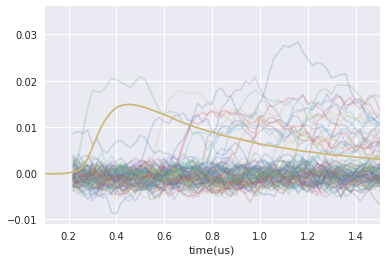

In [53]:
%matplotlib inline
# Plots 2 Photons traces as a check
plt.figure()
hpa.pplot(filelist_cont[mask_2ph_cont][0:1000], height_th, plot_every=10)
# plt.plot(time_f*1e6,signal_f, label='single photon model')
plt.legend()
plt.xlim(0.1,1.5);
plt.plot(time_f*1e6+0.3, signal_f)
# plt.savefig(results_directory+'persist_cont.pdf')

## OPTIMISE AND TEST MCMC & LEAST SQUARES FITS

In [68]:
# MCMC
def fit_two_mcmc(time, signal, 
                 amplitude_init_min=0.7, amplitude_init_max=1.5, 
                 one_x_offset_init=None, 
                 Plot=False, debug=False, 
                 sampling=7e3, burn=20, thin=6,
                auto=False):
    
    # LIMIT SEARCH FOR OFFSETS
    _t_initial=time[pd.srlatch_rev(signal,0)][0] 
#     _t_final=time[pd.srlatch_rev(signal,np.min(signal))][-1] 
    _t_final=time[pd.srlatch_rev(signal,0)][-1] 
    
    def model(x, f): 
        # PRIORS
        y_err = sigma0
        print (_t_initial,_t_final, one_x_offset_init)
        one_x_offset = pymc.Uniform("one_x_offset", _t_initial, _t_final, value=_t_initial)
        two_x_offset = pymc.Uniform("two_x_offset", _t_initial, _t_final, value=_t_final)
#         one_x_amplitude = pymc.Normal("one_x_amplitude", mu=1, tau=1.0/((sigma/mu)**2), value=1) #sigma/mu is the n=1 std deviation in units of n=1 amplitude
#         two_x_amplitude = pymc.Normal("two_x_amplitude", mu=1, tau=1.0/((sigma/mu)**2), value=1)
        one_x_amplitude = pymc.TruncatedNormal("one_x_amplitude", mu=1, tau=1.0/((sigma/mu)**2), a=th[0][0]/mu, b=th[1][0]/mu, value=1) #sigma/mu is the n=1 std deviation in units of n=1 amplitude
        two_x_amplitude = pymc.TruncatedNormal("two_x_amplitude", mu=1, tau=1.0/((sigma/mu)**2), a=th[0][0]/mu, b=th[1][0]/mu, value=1)
        # MODEL
        @pymc.deterministic(plot=False)
        def mod_two_pulse(x=time, 
                          one_x_offset=one_x_offset, 
                          two_x_offset=two_x_offset, 
                          one_x_amplitude=one_x_amplitude, 
                          two_x_amplitude=two_x_amplitude):
              return one_pulse(x, x_offset=one_x_offset, amplitude=one_x_amplitude)+\
            one_pulse(x, x_offset=two_x_offset, amplitude=two_x_amplitude)

        #likelihoodsy
        y = pymc.Normal("y", mu=mod_two_pulse, tau= 1.0/y_err**2, value=signal, observed=True)
        return locals()

    MDL = pymc.MCMC(model(time,signal), db='pickle') # The sample is stored in a Python serialization (pickle) database
    MDL.use_step_method(pymc.AdaptiveMetropolis, 
        [MDL.one_x_amplitude, MDL.two_x_amplitude],
        scales={MDL.one_x_amplitude:sigma/mu, 
                MDL.two_x_amplitude:sigma/mu}, 
        )
    if auto: 
        # uses Raftery Lewis to determine fit Parameters per trace: 
        # https://pymc-devs.github.io/pymc/modelchecking.html#convergence-diagnostics
        
        # pilot run
        InitSamples = 4*len(time)
        InitMDL = MDL
        InitMDL.sample(iter=InitSamples, burn=int(InitSamples*.5), thin=10)
        pymc_diagnostic = pymc.raftery_lewis(InitMDL, q=0.025, r=0.02, verbose=0) 
        [EstBurn, EstSampling, EstThin] = np.max(
            np.array(
                [pymc_diagnostic[i] for i in pymc_diagnostic.keys()[1:]] # first key: mod_two_pulse irrelavent
            ),
            axis=0)[2:] # first 2 diagnostics: 1st order Markov Chain irrelavent
        print [EstBurn, EstSampling, EstThin]
        # actual run
        MDL.sample(iter=EstSampling, burn=EstBurn, thin=EstThin, verbose=0)
    else:
        MDL.sample(iter=sampling, burn=burn, thin=thin, verbose=0)  
    # thin: consider every 'thin' samples
    # burn: number of samples to discard: decide by num of samples to run till parameters stabilise at desired precision
    if Plot:
        y_fit = MDL.mod_two_pulse.value #get mcmc fitted values
        plt.plot(time, signal, 'b', marker='o', ls='-', lw=1, label='Observed')
        plt.plot(time,y_fit,'k', marker='+', ls='--', ms=5, mew=2, label='Bayesian Fit Values')
        plt.legend()      
    if debug:
        pymc.Matplot.plot(MDL)
    return MDL #usage: MDL.one_x_offset.value for fitted result

### Step 4: update the mask for MCMC so that it fits a shorter pulse to save iterations

In [ ]:
# LEAST SQUARES - performs also MCMC within it
# Use average pulse to generate single photon model
def one_pulse(x, x_offset=0, amplitude=1):
    """convert the sample single photon pulse into a function
    that can be used in a fit
    """
    x = x - x_offset
    return amplitude * np.interp(x, time_f, signal_f)

two_pulse_fit = Model(one_pulse, prefix='one_') + \
        Model(one_pulse, prefix='two_')

def fit_two(time, signal, 
            sampling, burn, thin,
            height_th=height_th, 
            debug=False):
    """
    This Version has no trigger that switches between MCMC and least squares.
    It is used for debugging MCMC
    """
    # Use MCMC
    result_mcmc = fit_two_mcmc(time[clamp][::10], signal[clamp][::10], 
                               sampling=sampling, 
                               burn=burn,
                               thin=thin,
                               debug=debug)
    
    # Use Least Squares
    p = Parameters()
    p.add('one_x_offset', result_mcmc.one_x_offset.value, vary=1)
    p.add('two_x_offset', result_mcmc.two_x_offset.value, vary=1)
    p.add('one_amplitude', 
          result_mcmc.one_x_amplitude.value, 
          min=th[0][0]/mu, max=th[1][0]/mu, vary=1) #warning: max >= 2 causes n=2 & noise to be fitted on a tau~0 2ph trace. 
    p.add('two_amplitude', 
          result_mcmc.two_x_amplitude.value, 
          min=th[0][0]/mu, max=th[1][0]/mu, vary=1)

    result = two_pulse_fit.fit(signal,
                               x=time,
                               params=p,
                               )
    return result, result_mcmc

In [ ]:
# LEAST SQUARES - performs also MCMC within it
# Use average pulse to generate single photon model
def one_pulse(x, x_offset=0, amplitude=1):
    """convert the sample single photon pulse into a function
    that can be used in a fit
    """
    x = x - x_offset
    return amplitude * np.interp(x, time_f, signal_f)

two_pulse_fit = Model(one_pulse, prefix='one_') + \
        Model(one_pulse, prefix='two_')

def fit_two_cw(time, signal, 
            sampling, burn, thin,
            height_th=height_th, 
            debug=False):
    
    # Identify Pulse Region
    [mask, clamp, edges, left_edges, right_edges] = pd.discriminator(time, signal, 
                                                                     dt_left=0*200e-9,
                                                                     dt_right=0*700e-9, 
                                                                     height_th=height_th, 
                                                                     Plot=True, 
                                                                     method=2)
    # Use method 2 sr latch reversed with extra time dt_right to manually adjust for additional pulse regions to be considered for the fit.
    # dt_right limit must be SMALLER than limit set for 2 photon selection
    
    # Some flags for debugging later
    mcmc_flag = False
    unequal_edges = False
    
    # Raise flags based on number of edges
    if len(left_edges)==len(right_edges):
        """full pulses"""
        if len(left_edges)>=2:
            """2 or more edges"""
            mcmc_flag = False
        if len(left_edges)==1:
            """1 edge comprising of overlapping photons"""
            mcmc_flag = True
    else:
        mcmc_flag = True
        unequal_edges = True
    
    if mcmc_flag==True:
        # Use MCMC
        result_mcmc = fit_two_mcmc(time[::1], signal[::1], 
                               sampling=sampling, 
                               burn=burn,
                               thin=thin,
                               debug=debug)
        
        # Use MCMC results to initialise least squares fit
        one_x_offset_init = result_mcmc.one_x_offset.value
        two_x_offset_init = result_mcmc.two_x_offset.value
        one_x_offset_init_min = None; one_x_offset_init_max = None
        two_x_offset_init_min = None; two_x_offset_init_max = None
        
        one_ampliude_init = result_mcmc.one_x_amplitude.value
        two_amplitude_init = result_mcmc.two_x_amplitude.value
        
    if mcmc_flag==False:
        one_x_offset_init = time[left_edges][0]
        two_x_offset_init = time[left_edges][1]
        one_x_offset_init_min = time[left_edges][0]; one_x_offset_init_max = time[right_edges][0]
        two_x_offset_init_min = time[left_edges][1]; two_x_offset_init_max = time[right_edges][1]
        one_ampliude_init = 1
        two_amplitude_init = 1
        
    # Use Least Squares on all cases
    p = Parameters()
    p.add('one_x_offset', 
          one_x_offset_init, 
          min=one_x_offset_init_min , max=one_x_offset_init_max, vary=1)
    p.add('two_x_offset', 
          two_x_offset_init, 
          min=two_x_offset_init_min , max=two_x_offset_init_max, vary=1)
    p.add('one_amplitude', 
          one_ampliude_init, 
          min=th[0][0]/mu, max=th[1][0]/mu, vary=1) #warning: max >= 2 causes n=2 & noise to be fitted on a tau~0 2ph trace. 
    p.add('two_amplitude', 
          two_amplitude_init, 
          min=th[0][0]/mu, max=th[1][0]/mu, vary=1)

    result = two_pulse_fit.fit(signal,
                               x=time,
                               params=p,
                               )
    
    return result, mcmc_flag, unequal_edges

In [14]:
# LEAST SQUARES - performs also MCMC within it
# Use average pulse to generate single photon model
def one_pulse(x, x_offset=0, amplitude=1):
    """convert the sample single photon pulse into a function
    that can be used in a fit
    """
    x = x - x_offset
    return amplitude * np.interp(x, time_f, signal_f)

two_pulse_fit = Model(one_pulse, prefix='one_') + \
        Model(one_pulse, prefix='two_')

def fit_two_mcmc_cw(time, signal, 
            sampling, burn, thin,
            height_th=height_th, 
            debug=False):
    
    # Identify Pulse Region
    [mask, clamp, edges, left_edges, right_edges] = pd.discriminator(time, signal, 
                                                                     dt_left=0*200e-9,
                                                                     dt_right=2*700e-9, 
                                                                     height_th=height_th, 
                                                                     Plot=False, 
                                                                     method=2)
    # Use method 2 sr latch reversed with extra time dt_right to manually adjust for additional pulse regions to be considered for the fit.
    
    # Some flags for debugging later
    overlap = False
    unequal_edges = False
    
    # Raise flags based on number of edges
    if len(left_edges)==len(right_edges):
        """full pulses"""
        if len(left_edges)>=2:
            """2 or more edges"""
            overlap = False
        if len(left_edges)==1:
            """1 edge comprising of overlapping photons"""
            overlap = True
    else:
        unequal_edges = True
    
    if overlap or unequal_edges: sampling = sampling
    else: sampling, burn, thin = int(sampling/3), int(burn/3), int(thin/3)
        
    # Use MCMC
    result_mcmc = fit_two_mcmc(time[clamp][::10], signal[clamp][::10], 
                           sampling=sampling, 
                           burn=burn,
                           thin=thin,
                           debug=debug)
    
    return result_mcmc, overlap, unequal_edges

# MCMC Optimisation
### Step 5: Predict MCMC Parameters

In [ ]:
# Test on a single trace
# mdl = fit_two_mcmc(*hpa.trace_extr(filelist_cont[mask_2ph_cont][0], t_initial, t_final), sampling=1.5e4)

In [55]:
t_initial, t_final

(None, None)

## tests MCMC with diagnosis

In [56]:
def testmcmc(i, sampling, burn, thin, height_th, Plot=True):
    result, result_mcmc = fit_two(*hpa.trace_extr(filelist_cont[mask_2ph_cont][i], 
                                                  t_initial, t_final), 
                            
                                  height_th=height_th, 
                                  sampling=sampling,
                                 burn=burn,
                                 thin=thin)
    # pymc.gelman_rubin() #https://pymc-devs.github.io/pymc/modelchecking.html
    if Plot:
        plt.figure()
        plt.plot(*hpa.trace_extr(filelist_cont[mask_2ph_cont][i]), label='unwindowed')
        plt.plot(result_mcmc.time, result_mcmc.signal, 'b', marker='o', ls='-', lw=1, label='Observed')
        plt.plot(result_mcmc.time, result_mcmc.mod_two_pulse.value,'k', marker='+', ls='--', ms=5, mew=2, label='Bayesian Fit Values')
        plt.savefig(results_directory+'testmcmc.pdf')
        plt.legend()
        print result.fit_report()
        print ('arrival time difference = {:.2f}ns'.\
               format((result.init_values['one_x_offset']-result.init_values['two_x_offset'])*1e9))
        pymc.Matplot.plot(result_mcmc)
    return result, result_mcmc

## tests MCMC / Least Squares with triggering

In [66]:
def testcw(i, sampling, burn, thin, height_th, Plot=True):
    result, mcmc_flag, unequal_edges = fit_two_cw(*hpa.trace_extr(filelist_cont[mask_2ph_cont][i], 
                                                  t_initial, t_final), 
                            
                                  height_th=height_th, 
                                  sampling=sampling,
                                 burn=burn,
                                 thin=thin,
                                debug=True)
    # pymc.gelman_rubin() #https://pymc-devs.github.io/pymc/modelchecking.html
    if Plot:
        plt.figure()
        plt.plot(*hpa.trace_extr(filelist_cont[mask_2ph_cont][i]), label='unwindowed', color='grey')
        result.plot_fit()
        plt.savefig(results_directory+'testmcmccw.pdf')
        print result.fit_report()
        print ('arrival time difference = {:.2f}ns'.\
               format((result.init_values['one_x_offset']-result.init_values['two_x_offset'])*1e9))
    return result, mcmc_flag, unequal_edges

## tests MCMC with triggering

In [ ]:
def testmcmccw(i, sampling, burn, thin, height_th, Plot=True):
    result_mcmc, overlap, unequal_edges = fit_two_mcmc_cw(*hpa.trace_extr(filelist_cont[mask_2ph_cont][i], 
                                                  t_initial, t_final), 
                            
                                  height_th=height_th, 
                                  sampling=sampling,
                                 burn=burn,
                                 thin=thin,
                                debug=False)
    # pymc.gelman_rubin() #https://pymc-devs.github.io/pymc/modelchecking.html
    if Plot:
        plt.figure()
        plt.plot(*hpa.trace_extr(filelist_cont[mask_2ph_cont][i]), label='unwindowed')
        plt.plot(result_mcmc.time, result_mcmc.signal, 'b', marker='o', ls='-', lw=1, label='Observed')
        plt.plot(result_mcmc.time, result_mcmc.mod_two_pulse.value,'k', marker='+', ls='--', ms=5, mew=2, label='Bayesian Fit Values')
        plt.savefig(results_directory+'testmcmc.pdf')
        plt.legend()
#         print result.fit_report()
#         print ('arrival time difference = {:.2f}ns'.\
#                format((result.init_values['one_x_offset']-result.init_values['two_x_offset'])*1e9))
        pymc.Matplot.plot(result_mcmc)
    return result_mcmc, overlap, unequal_edges

In [ ]:
a, b, c = testcw(3,sampling=1.5e4,burn=40,thin=10,
                height_th=height_th,Plot=True);

### Step 5.1: edit precision desired through q, r

In [ ]:
# Perform Diagnostic on a sample trace to determine the recommended fitting params
pymc_diagnostic = pymc.raftery_lewis(b, q=0.025, r=0.01);
pymc_diagnostic
# print np.array([pymc_diagnostic[i] for i in pymc_diagnostic.keys()[1:]])

# MultiProcess 2 photon traces 

### Step 6: 
### * Edit t_initial and t_final windows to save convergence time - warning: too short a time period will affect background estimation accuracy!
### * Update sampling, burn and thin based on optimised parameters in Step 5

In [43]:
# Initialise telegram to message progress
from telegram.bot import Bot
uid='304462759'
token='351459283:AAH5Gyojsh69DtecyxFuCm_Rha4i8QNMSZo'
sender_bot=Bot(token=token)
sender_bot.sendMessage(chat_id=uid,text='testing')

<IPython.core.display.Javascript object>


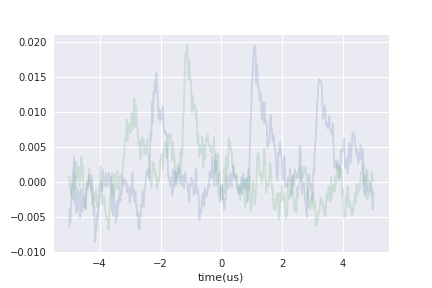

In [24]:
hpa.pplot(filelist_cont[mask_2ph_cont][:19],height_th)

In [86]:
filelist_cont[mask_2ph_cont][0].split('/')[-1].split('.trc')[0]

'C2_continuous_diode_20MHz_bwl_TES5_80mK_93.7uA_00013'

In [ ]:
import multiprocess as mp
from multiprocess import Pool
tasks = np.array(filelist_cont[mask_2ph_cont])
counter = mp.Value('i',0)
p = Pool(8)

def fit_two_poolable(file):
    try:
    #     print '{} fit started'.format(file)
        time, signal = hpa.trace_extr(file, t_initial=None, t_final=None)
        result, mcmc_flag, unequal_edges = fit_two_cw(time, signal, 
                                                height_th=height_th,
                                                sampling=1.5e4,burn=40,thin=10)
        # saves fit object
        fname = file.split('/')[-1].split('.trc')[0]
#         fileObject = open(results_directory+'mcmc_fit_results/'+fname+'_mcmc_data_cont','wb')
#         pickle.dump(result_mcmc, fileObject)
#         fileObject.close()
        
        counter.value+=1
        times_toupdate = 20
        text_tosend = '\nProcess finished:'+ '%.1f'%(counter.value/len(tasks)*100) + "%"
        print text_tosend
        try:
            if counter.value % int(len(tasks)/times_toupdate) == 0:
                sender_bot.sendMessage(chat_id=uid,text=text_tosend)
        except:
            pass
    #     print '{} fit ended'.format(file)
        
        return result, fname, mcmc_flag, unequal_edges
#         [result_mcmc.one_x_offset.value,result_mcmc.two_x_offset.value,result_mcmc.one_x_amplitude.value, result_mcmc.two_x_amplitude.value,overlap,unequal_edges]
    except:
        pass #if file is corrupt

results_cont = p.map(fit_two_poolable,
                    tasks)
print results_cont
# Pickle Results
import pickle
fileObject = open(results_directory+'lmfit_data_cont_areawin_dt_200_1200_mask_srrev_dt_0_0_2nspp','wb')
pickle.dump(results_cont, fileObject)
fileObject.close()
# results_cont=np.array([r for r in results_cont if r!= None]) #removes corrupt entries
# np.savetxt(results_directory+'results_cont.dat',results_cont)

(-2.8960582357443424e-06, -1.9640582621031025e-06, None)

Process finished:0.0%

Process finished:0.1%

Process finished:0.1%
Process finished:0.1%


Process finished:0.2%

Process finished:0.3%

Process finished:0.2%

Process finished:0.3%
(1.3859352893618128e-06, 2.6279352542356539e-06, None)

Process finished:0.3%
(-4.3900662801337365e-06, -3.0380663183709079e-06, None)

Process finished:0.4%

Process finished:0.4%

Process finished:0.4%

Process finished:0.5%
(-1.0420617538830151e-06, 6.3793819860334001e-07, None)

Process finished:0.5%

Process finished:0.6%
(-4.4400645458676545e-06, -3.4100645749980439e-06, None)
(-5.0000581762391586e-06, 2.4559416128907604e-06, None)

Process finished:0.6%
(2.009939315035187e-06, 2.8639392908824176e-06, None)
 [-                 5%                  ] 782 of 15000 complete in 0.5 sec
Process finished:0.6%

Process finished:0.7%

Process finished:0.7%
 [--                5%                  ] 821 of 15000 complete in 0.5 sec
Process finished:0.7%


 [----             12%                  ] 1919 of 15000 complete in 2.0 secec
Process finished:7.0%

Process finished:7.0%
(-3.7320593673353055e-06, 4.9619403867815823e-06, None)
 [---------        25%                  ] 3822 of 15000 complete in 5.0 sec
Process finished:7.0%
 [------           15%                  ] 2383 of 15000 complete in 3.0 sec
Process finished:7.1%
 [----------       27%                  ] 4092 of 15000 complete in 5.5 sec
Process finished:7.1%
(-3.2940616901921046e-06, -1.8100617321624909e-06, None)

Process finished:7.2%
 [------           18%                  ] 2704 of 15000 complete in 3.5 sec
Process finished:7.2%
 [-----------      29%                  ] 4370 of 15000 complete in 6.0 sec
Process finished:7.2%

Process finished:7.3%
 [-                 4%                  ] 659 of 15000 complete in 0.5 sec
Process finished:7.3%
 [-------          20%                  ] 3025 of 15000 complete in 4.0 sec
Process finished:7.3%
 [-----------      31%           

 [-----------      30%                  ] 4532 of 15000 complete in 6.5 sec
Process finished:14.1%
(-2.9820628542507251e-06, -9.7406291104084345e-07, None)
 [------------     32%                  ] 4827 of 15000 complete in 7.0 sec
Process finished:14.1%
 [-                 3%                  ] 530 of 15000 complete in 0.5 sec
Process finished:14.2%
 [------------     34%                  ] 5117 of 15000 complete in 7.5 sec
Process finished:14.2%

Process finished:14.2%

Process finished:14.3%

Process finished:14.3%
 [-------------    36%                  ] 5409 of 15000 complete in 8.0 sec
Process finished:14.3%
(2.1219404671022685e-06, 3.4919404283560224e-06, None)

Process finished:14.4%

Process finished:14.4%
 [---               9%                  ] 1460 of 15000 complete in 1.5 sec
Process finished:14.4%
 [--------------   38%                  ] 5701 of 15000 complete in 8.5 sec
Process finished:14.5%
 [-                 4%                  ] 707 of 15000 complete in 0.5 sec
P

Process finished:20.0%
 [-                 3%                  ] 488 of 15000 complete in 0.5 secc(-2.5120611346912465e-06, -1.0040611773403992e-06, None)

Process finished:20.0%
 [------           17%                  ] 2674 of 15000 complete in 2.5 secec(-4.3820697460639629e-06, -3.0300697843011343e-06, None)
 [------           18%                  ] 2747 of 15000 complete in 2.5 sec
Process finished:20.1%
 [----------       27%                  ] 4111 of 15000 complete in 6.0 sec(-2.5640622884552431e-06, -1.5320623176421964e-06, None)
 [-----------------92%---------------   ] 13868 of 15000 complete in 19.5 sec
Process finished:20.1%

Process finished:20.1%
 [-----------------72%-------           ] 10901 of 15000 complete in 17.0 sec
Process finished:20.2%
 [-----------------85%------------      ] 12767 of 15000 complete in 20.0 sec(1.8179364323786754e-06, 3.0039363988363047e-06, None)
 [-----------------54%                  ] 8182 of 15000 complete in 11.0 secc
Process finished:20.

 [--------         21%                  ] 3271 of 15000 complete in 3.5 sec(-3.940629274443637e-07, 9.0193703590225312e-07, None)

Process finished:25.5%
 [------           18%                  ] 2755 of 15000 complete in 3.5 sec(-4.7140639605010768e-06, -3.2960640006048556e-06, None)
 [-----------      30%                  ] 4548 of 15000 complete in 6.5 secc
Process finished:25.6%
 [-------          19%                  ] 2973 of 15000 complete in 3.5 sec(-2.2320622978448452e-06, -1.354062322676381e-06, None)
 [-----------------98%----------------- ] 14818 of 15000 complete in 23.0 sec
Process finished:25.6%
 [-----------------100%-----------------] 15000 of 15000 complete in 23.4 sec
Process finished:25.7%
(-5.0000662628817583e-06, 2.2519335320176747e-06, None)
(4.9593993547135976e-07, 1.885939896159475e-06, None)
 [-                 3%                  ] 589 of 15000 complete in 0.5 sec
Process finished:25.7%
 [--                7%                  ] 1127 of 15000 complete in 1.0 s

Process finished:32.2%

Process finished:32.3%
 [------           15%                  ] 2376 of 15000 complete in 3.0 sec(1.5559439488138127e-06, 2.8719439115947909e-06, None)
(-5.0000685733510723e-06, 1.5279312420244791e-06, None)
 [---               8%                  ] 1288 of 15000 complete in 1.0 sec
Process finished:32.3%
 [--                5%                  ] 831 of 15000 complete in 1.0 sec
Process finished:32.3%
 [------           18%                  ] 2748 of 15000 complete in 3.5 sec
Process finished:32.4%
 [--------         21%                  ] 3278 of 15000 complete in 4.5 sec(-1.632066935752632e-06, -3.6206697167068496e-07, None)
 [--------         21%                  ] 3200 of 15000 complete in 4.0 sec
Process finished:32.4%
 [-------          20%                  ] 3072 of 15000 complete in 4.0 sec
Process finished:32.4%
 [---------        23%                  ] 3576 of 15000 complete in 5.0 sec
 [-                 2%                  ] 440 of 15000 complete in

Process finished:39.1%
 [-                 3%                  ] 530 of 15000 complete in 0.5 sec
Process finished:39.1%

Process finished:39.2%

Process finished:39.2%

Process finished:39.3%
 [--                6%                  ] 1042 of 15000 complete in 1.0 sec(-1.880069239208027e-06, -5.1606927778458149e-07, None)

Process finished:39.3%

Process finished:39.3%
 [---               9%                  ] 1472 of 15000 complete in 1.5 sec
Process finished:39.4%

Process finished:39.4%
 [-                 3%                  ] 476 of 15000 complete in 0.5 sec
Process finished:39.4%

Process finished:39.5%
(1.1519335631277993e-06, 4.999933454298927e-06, None)

Process finished:39.5%

Process finished:39.6%
 [----             12%                  ] 1869 of 15000 complete in 2.0 sec(-4.3660616598738749e-06, -3.5320616834610058e-06, None)
(-2.7800593942597034e-06, -1.5520594289899153e-06, None)
 [----             12%                  ] 1903 of 15000 complete in 2.0 sec
Process finished

Process finished:46.6%
 [------------     31%                  ] 4753 of 15000 complete in 7.0 sec
Process finished:46.6%
 [--------------   38%                  ] 5826 of 15000 complete in 8.5 sec(1.5859387494093975e-06, 2.5639387217496685e-06, None)
 [-----------------100%-----------------] 15000 of 15000 complete in 22.9 sec
Process finished:46.7%
(-2.3040634510432031e-06, 4.9999363423855695e-06, None)
 [---               9%                  ] 1444 of 15000 complete in 1.5 sec
Process finished:46.7%
(1.0239399205384999e-06, 2.4679398796993909e-06, None)
 [----             12%                  ] 1800 of 15000 complete in 2.0 sec
Process finished:46.7%
Process finished:46.8%

 [-                 4%                  ] 630 of 15000 complete in 0.5 sec
Process finished:46.8%

Process finished:46.8%
 [-----            14%                  ] 2150 of 15000 complete in 2.5 sec
Process finished:46.9%
(-2.9420657434686448e-06, 4.9999340319162555e-06, None)
(-3.6380657237844205e-06, -2.75406574

 [-----------------100%-----------------] 15000 of 15000 complete in 24.1 sec
Process finished:49.5%

Process finished:49.6%

Process finished:49.6%

Process finished:49.6%

Process finished:49.7%

Process finished:49.7%
(-4.7006639099890787e-07, 1.6559335488737058e-06, None)

Process finished:49.8%

Process finished:49.8%
 [-                 3%                  ] 518 of 15000 complete in 0.5 sec(-5.0000587538564879e-06, 4.569940975485428e-06, None)
 [---               9%                  ] 1412 of 15000 complete in 1.5 sec
Process finished:49.8%
 [--                7%                  ] 1114 of 15000 complete in 1.0 sec
Process finished:49.9%

Process finished:49.9%

Process finished:49.9%
 [----             12%                  ] 1800 of 15000 complete in 2.0 sec
Process finished:50.0%
 [---              10%                  ] 1516 of 15000 complete in 1.5 sec
Process finished:50.0%

Process finished:50.1%
(-8.2206811389565347e-07, 4.9999317214469415e-06, None)

Process finished:50.1

 [-----------------49%                  ] 7489 of 15000 complete in 10.5 sec
Process finished:55.4%
 [----------       28%                  ] 4303 of 15000 complete in 5.5 secc(-1.2880669454816164e-06, -3.5606697184037655e-07, None)
 [-----------------89%-------------     ] 13364 of 15000 complete in 21.5 sec
Process finished:55.4%
 [-----------------93%---------------   ] 14094 of 15000 complete in 23.0 sec(3.3193300870165461e-07, 4.9999328766815985e-06, None)
 [-                 3%                  ] 588 of 15000 complete in 0.5 secsec
Process finished:55.4%
 [-----------------92%---------------   ] 13948 of 15000 complete in 22.5 sec
Process finished:55.5%

Process finished:55.5%

Process finished:55.5%
 [-----------------97%----------------- ] 14691 of 15000 complete in 24.0 sec
Process finished:55.6%
 [-----------------94%----------------  ] 14232 of 15000 complete in 23.0 sec
Process finished:55.6%

Process finished:55.7%

Process finished:55.7%
 [-----------------100%-----------

 [-----------------87%-------------     ] 13193 of 15000 complete in 21.5 sec
Process finished:60.5%
 [-----------------97%----------------  ] 14605 of 15000 complete in 24.5 sec
Process finished:60.6%
 [-----------------76%--------          ] 11409 of 15000 complete in 18.0 sec
 [------           16%                  ] 2472 of 15000 complete in 2.5 sec

Process finished:60.6%
 [-----------------89%--------------    ] 13475 of 15000 complete in 22.0 sec
Process finished:60.7%
 [-----------------99%----------------- ] 14881 of 15000 complete in 25.0 sec(2.301939306776863e-06, 3.3479392771939627e-06, None)
 [---------        25%                  ] 3866 of 15000 complete in 4.5 secec
Process finished:60.7%
 [-----------------90%--------------    ] 13641 of 15000 complete in 22.5 sec
Process finished:60.7%
 [-----------------97%----------------  ] 14601 of 15000 complete in 24.0 sec(-3.8380593643374199e-06, -2.5860593997463981e-06, None)
 [-----------------48%                  ] 7214 of 15

 [------           17%                  ] 2654 of 15000 complete in 3.0 sec
Process finished:63.2%
 [-----------------62%---               ] 9371 of 15000 complete in 14.5 sec
Process finished:63.2%

Process finished:63.3%
 [-----------------56%-                 ] 8492 of 15000 complete in 12.5 secc
Process finished:63.3%
 [-------          20%                  ] 3044 of 15000 complete in 3.5 sec
Process finished:63.3%
 [-----------------64%----              ] 9658 of 15000 complete in 15.0 sec
Process finished:63.4%

Process finished:63.4%
 [-----------------58%--                ] 8769 of 15000 complete in 13.0 secc
Process finished:63.4%
 [--------         22%                  ] 3419 of 15000 complete in 4.0 sec
Process finished:63.5%
 [-----------------66%-----             ] 9959 of 15000 complete in 15.5 sec
Process finished:63.5%
 [-----------------60%--                ] 9033 of 15000 complete in 13.5 secc(5.3593473578412607e-07, 2.3539346843675747e-06, None)
 [-----------------83

 [-----------------73%-------           ] 11041 of 15000 complete in 17.5 sec
Process finished:68.1%
 [-----------------90%--------------    ] 13551 of 15000 complete in 21.0 sec
Process finished:68.2%

Process finished:68.2%

Process finished:68.2%
 [-----------------92%---------------   ] 13845 of 15000 complete in 21.5 sec(-4.6580576082942507e-06, -2.6560576649146774e-06, None)
 [----             11%                  ] 1658 of 15000 complete in 1.5 secec
Process finished:68.3%
 [-----            13%                  ] 2043 of 15000 complete in 2.0 secec
Process finished:68.3%

Process finished:68.3%
 [-----------------85%------------      ] 12768 of 15000 complete in 20.5 sec
Process finished:68.4%
 [-----            15%                  ] 2365 of 15000 complete in 2.5 sec
Process finished:68.4%

Process finished:68.4%

 [-----------------75%--------          ] 11281 of 15000 complete in 16.0 sec
 [-----------------87%-------------     ] 13050 of 15000 complete in 21.0 sec
Process f

 [-----------------100%-----------------] 15000 of 15000 complete in 24.7 sec
Process finished:74.4%
 [-----------------76%---------         ] 11514 of 15000 complete in 18.5 sec(-1.9160657724859065e-06, -9.1806580071127408e-07, None)
 [------           16%                  ] 2515 of 15000 complete in 2.5 secec
Process finished:74.4%
 [--------         21%                  ] 3299 of 15000 complete in 4.0 sec
Process finished:74.5%
 [---------        23%                  ] 3588 of 15000 complete in 3.0 sec
Process finished:74.5%
 [-------          19%                  ] 2891 of 15000 complete in 3.0 secec(-4.6940599177454159e-06, -2.9540599669559767e-06, None)
 [-                 4%                  ] 690 of 15000 complete in 0.5 seccec
Process finished:74.5%
 [---------        26%                  ] 3912 of 15000 complete in 5.0 sec
 [-----------      29%                  ] 4375 of 15000 complete in 4.0 sec

Process finished:74.6%
 [-----------------92%---------------   ] 13893 of 1500

Process finished:79.9%
 [-----------------95%----------------  ] 14397 of 15000 complete in 23.5 sec(4.959370473847173e-07, 1.8539370089778544e-06, None)
 [-----------------100%-----------------] 15000 of 15000 complete in 24.8 sec
Process finished:79.9%
 [-----------------76%---------         ] 11504 of 15000 complete in 19.0 sec(-3.032061119984643e-06, -2.1320611454383813e-06, None)
 [-------          19%                  ] 2948 of 15000 complete in 2.5 secec
Process finished:79.9%

Process finished:80.0%

 [-----------------47%                  ] 7143 of 15000 complete in 10.5 sec
 [-----------------88%-------------     ] 13256 of 15000 complete in 22.0 sec(1.6793647904386232e-07, 1.7299364348674854e-06, None)
 [--------         22%                  ] 3365 of 15000 complete in 3.0 sec(-1.982066925853956e-06, -5.2806696697588434e-07, None)
 [-----            14%                  ] 2120 of 15000 complete in 2.5 secec
Process finished:80.1%
 [-----            13%                  ] 199

 [-----------------69%------            ] 10400 of 15000 complete in 15.0 sec
Process finished:85.4%
 [-----------------71%-------           ] 10703 of 15000 complete in 15.5 sec(-4.4880633892754648e-06, -2.7220634392213557e-06, None)
 [-----            15%                  ] 2277 of 15000 complete in 2.0 secec
Process finished:85.4%

Process finished:85.5%

Process finished:85.5%
 [---------        25%                  ] 3766 of 15000 complete in 4.0 secec(-1.9040628847386472e-06, -9.4006291200242912e-07, None)
 [----------       28%                  ] 4307 of 15000 complete in 5.0 secec
Process finished:85.6%

Process finished:85.6%

Process finished:85.6%
 [-------------    36%                  ] 5432 of 15000 complete in 7.0 secec
Process finished:85.7%
 [-----------------93%---------------   ] 14071 of 15000 complete in 21.0 sec
Process finished:85.7%
 [-----------      30%                  ] 4624 of 15000 complete in 5.5 sec
Process finished:85.7%

Process finished:85.8%
(-2.8640

 [-----------------96%----------------  ] 14472 of 15000 complete in 18.0 sec
Process finished:91.2%
 [--                6%                  ] 982 of 15000 complete in 1.0 sec
Process finished:91.2%

Process finished:91.2%

Process finished:91.3%
 [-----------------98%----------------- ] 14839 of 15000 complete in 18.5 sec
Process finished:91.3%
 [---               9%                  ] 1390 of 15000 complete in 1.5 sec(1.315934136106891e-06, 2.8419340929486636e-06, None)
 [------           17%                  ] 2642 of 15000 complete in 3.0 secec
Process finished:91.3%
 [----             10%                  ] 1632 of 15000 complete in 1.5 sec(2.8393647576315827e-07, 1.9259364293242268e-06, None)
 [------------     31%                  ] 4764 of 15000 complete in 5.5 secec
Process finished:91.4%

Process finished:91.4%
 [--------         23%                  ] 3450 of 15000 complete in 4.0 sec(-3.7140616783136943e-06, -2.8080617039371242e-06, None)
 [---------        25%             

 [-----------------84%------------      ] 12716 of 15000 complete in 19.0 sec
Process finished:93.9%
 [-----------------87%-------------     ] 13072 of 15000 complete in 19.5 sec(-5.0000633747951159e-06, 3.5119363844690835e-06, None)
 [-----------------96%----------------  ] 14539 of 15000 complete in 22.0 sec
 [------           17%                  ] 2642 of 15000 complete in 2.5 sec

Process finished:94.0%

Process finished:94.0%
(-2.4160663359622692e-06, -1.1006640118040319e-07, None)

Process finished:94.0%

Process finished:94.1%
 [-------          20%                  ] 3008 of 15000 complete in 3.0 secec(-7.2806291799819859e-07, 4.3793704902506932e-07, None)
 [--------------   37%                  ] 5673 of 15000 complete in 7.5 seccc
Process finished:94.1%

Process finished:94.1%
 [-----------------58%--                ] 8807 of 15000 complete in 12.5 sec
Process finished:94.2%
 [-----------------53%                  ] 8071 of 15000 complete in 10.5 sec(-3.1960634258157202e-06,

In [45]:
print np.sum(mask_2ph_cont%8)
print len(results_cont)
print len(tasks)

The history saving thread hit an unexpected error (OperationalError('database or disk is full',)).History will not be written to the database.2713

2713
2713


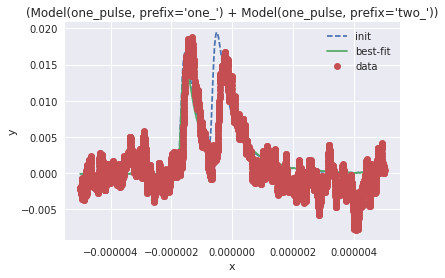

In [49]:
plt.figure()
results_cont[1][0].plot_fit()

In [4]:
import pickle
fileObject = open(results_directory+'lmfit_data_cont_areawin_dt_200_1200_mask_srrev_dt_0_0_2nspp','wb')
pickle.dump(results_cont, fileObject)
fileObject.close()

NameError: name 'results_cont' is not defined

### Check Results / Pickled Results

In [8]:
MyPickleObject = open(results_directory+'lmfit_data_cont_areawin_dt_200_1200_mask_srrev_dt_0_0','r')  
PickleObject = pickle.load(MyPickleObject) # Make sure you have enough memory to do this!
results_cont = PickleObject #Omit if don't want to get results from pickle

In [9]:
np.array(results_cont)[0][0]

In [11]:
# Optional: Formatting of saved results so that it is accepatble to pf.extract, 
# that only accepts a list of lmfit objects
results = np.array(results_cont)
results = results[results!=np.array(None)] # omit corrupted files
results = results.reshape(int(len(results)/4),4)
results_formatted_cont = []
fnames=[]
mcmc_flags=[]
unequal_edges=[]
for r in results:
    results_formatted_cont.append(r[0])
    fnames.append(r[1])
    mcmc_flags.append(r[2])
    unequal_edges.append(r[3])

mcmc_flags = np.array(mcmc_flags).astype('bool')

In [219]:
processed_cont = pf.extract(results_formatted_cont)

In [12]:
print results_formatted_cont[0].init_values
print results_formatted_cont[0].values

{'one_x_offset': -4.3420628157872983e-06, 'one_amplitude': 1, 'two_amplitude': 1, 'two_x_offset': 1.6499370147473684e-06}
{'one_x_offset': -4.3420628157872983e-06, 'one_amplitude': 0.99045215885822446, 'two_amplitude': 0.87663608712173557, 'two_x_offset': 1.6499370147473684e-06}


In [13]:
one_x_offsets=[]
two_x_offsets=[]
one_amplitudes=[]
two_amplitudes=[]
for i, r in enumerate(results_formatted_cont):
    if mcmc_flags[i]==True:
        one_x_offsets.append(r.init_values['one_x_offset'])
        two_x_offsets.append(r.init_values['two_x_offset'])
        one_amplitudes.append(r.init_values['one_amplitude'])
        two_amplitudes.append(r.init_values['two_amplitude'])
    if mcmc_flags[i]==False:
        one_x_offsets.append(r.values['one_x_offset'])
        two_x_offsets.append(r.values['two_x_offset'])
        one_amplitudes.append(r.values['one_amplitude'])
        two_amplitudes.append(r.values['two_amplitude'])
one_x_offsets=np.array(one_x_offsets)
two_x_offsets=np.array(two_x_offsets)
one_amplitudes=np.array(one_amplitudes)
two_amplitudes=np.array(two_amplitudes)

In [14]:
abs_taus_cont = np.abs(one_x_offsets-two_x_offsets)*1e9

## Absolute Time Separation

(642.15590849227362, 59.603885232692733)
fwhm = 140.367149723


/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


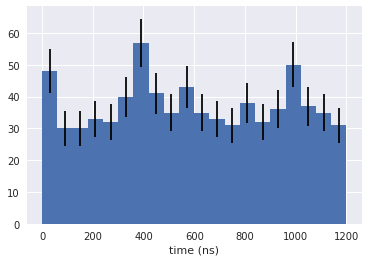

In [15]:
%matplotlib inline
mask_max_amp = np.minimum(one_amplitudes,two_amplitudes)>0.6
freq, bins = np.histogram(abs_taus_cont, 
                          bins=int(1200/60), 
                          range=(0,1200))
bins = bins[:-1]+np.diff(bins)[0]/2

plt.figure('arrival times _cont')
# plt.hist(abs_taus_cont, 20, range=(100,250), align='centre');
plt.bar(bins,freq,align='center',width=np.diff(bins)[0], yerr=np.sqrt(freq))
plt.xlabel('time (ns)')
plt.ylim(0,np.max(freq)*1.2)
# plt.ylim(0, 1000)
# plt.savefig(results_directory+'arrival_times_cont.pdf')
reload(sp)
# sp.FWHM(bins, freq, plot=True)
(m,s) = norm.fit(abs_taus_cont[(abs_taus_cont>550)&(abs_taus_cont<750)])
print (m,s)
print 'fwhm = {}'.format(2.355*s)

## Plot anomalies

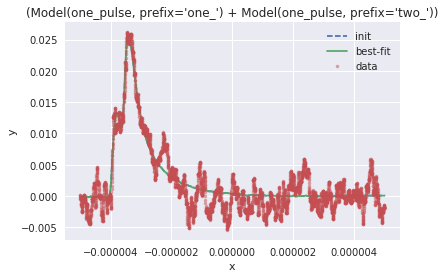

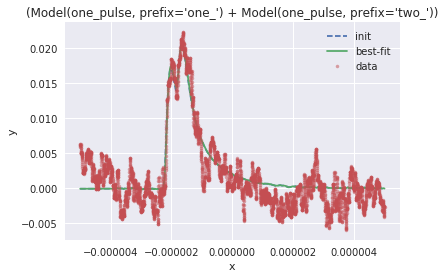

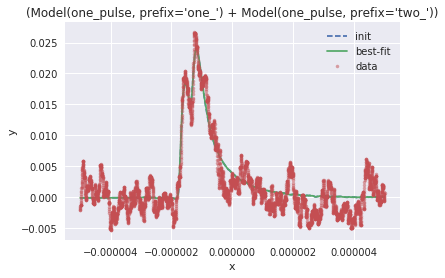

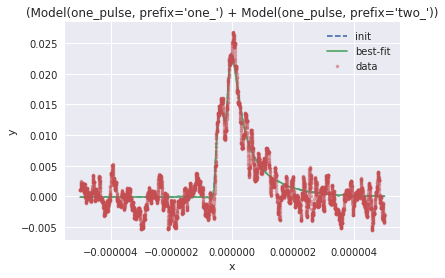

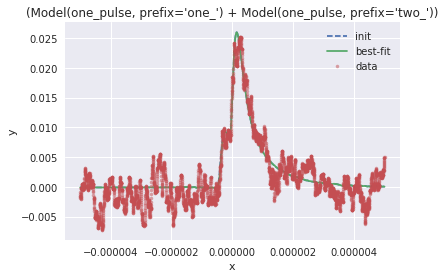

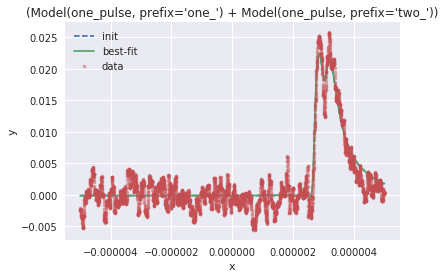

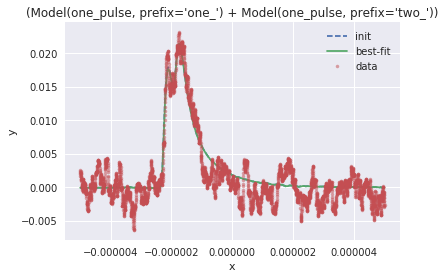

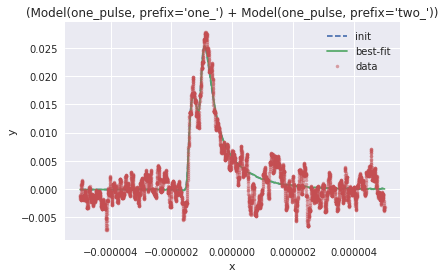

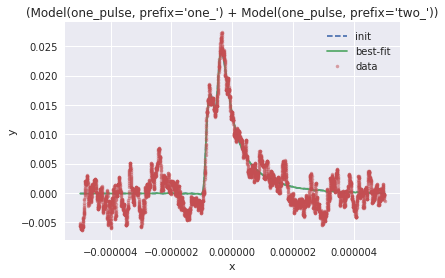

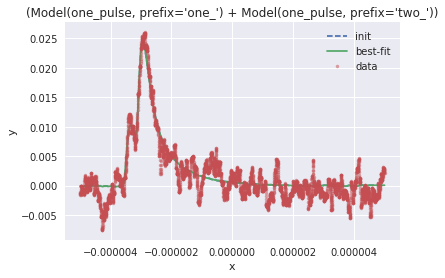

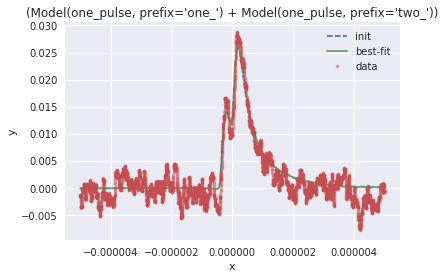

In [75]:
%matplotlib inline
mask = (abs_taus_cont>395)&(abs_taus_cont<405)
# print len(results_formatted_cont)
# print len(mask)
for i in np.arange(np.sum(mask)):
    plt.figure()
    np.array(results_formatted_cont)[mask][i].plot_fit(data_kws={'marker':".",'alpha':0.5})
    plt.savefig('abs_tau_395_to_405_ns_plots'+'/'+str(abs_taus_cont[mask][i])+'.pdf')

## Time Separation

In [16]:
taus_cont = (two_x_offsets-one_x_offsets)*1e9

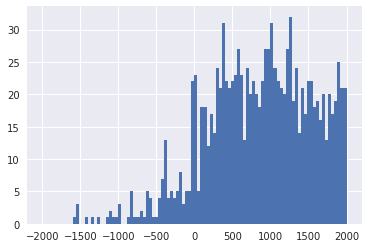

In [17]:
%matplotlib inline
plt.figure()
plt.hist((taus_cont),int(4000/40),range=(-2000,2000));
# plt.ylim(0,200)

## Separation vs Maximum or Sum of Amplitudes

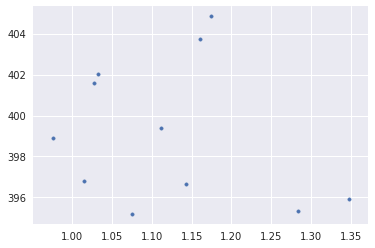

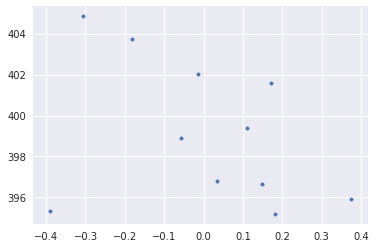

In [56]:
# mask=(taus_cont>0)&(taus_cont<80)

plt.scatter(np.maximum(one_amplitudes, two_amplitudes)[mask], abs_taus_cont[mask], marker='.')
plt.figure()
plt.scatter(((one_amplitudes-two_amplitudes)/(one_amplitudes+two_amplitudes))[mask], 
            abs_taus_cont[mask], 
            marker='.')

caption: 
single photon pulses leaking into 2 photon population caused the spike in 0-50ns bin increase in population 

it's effects decay as tau increases.

## Amplitude 1 vs Amplitude 2

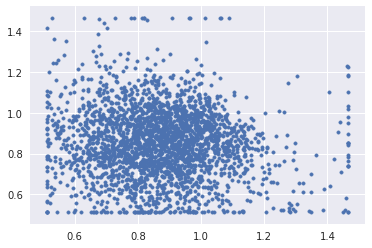

In [18]:
plt.scatter(one_amplitudes,two_amplitudes,marker='.')

## Histogram of Min, Max Ampltudes from Least Squares Fit

(array([  16.,   58.,  243.,  479.,  587.,  412.,   89.,   13.,    3.,   16.]),
 array([ 0.5126331 ,  0.60791876,  0.70320442,  0.79849008,  0.89377574,
         0.9890614 ,  1.08434706,  1.17963272,  1.27491838,  1.37020404,
         1.4654897 ]),
 <a list of 10 Patch objects>)

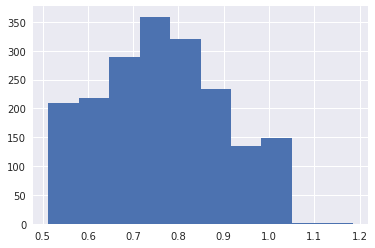

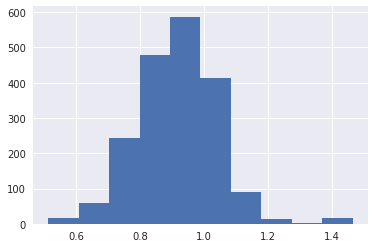

In [19]:
plt.hist(np.minimum(one_amplitudes,two_amplitudes)[~mcmc_flags])
plt.figure();plt.hist(np.maximum(one_amplitudes,two_amplitudes)[~mcmc_flags])

caption: amplitudes remain mostly at default values without change: justifies use of MCMC instead of least squares

## Maximum Amplitude is limited for cases when MCMC is activated

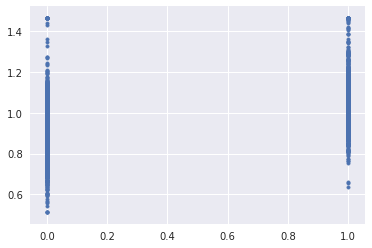

In [104]:
plt.scatter(mcmc_flags, np.maximum(one_amplitudes,two_amplitudes),marker='.')

(0, 80)

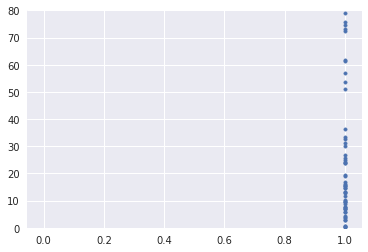

In [115]:
plt.scatter(mcmc_flags, abs_taus_cont, marker='.')
plt.ylim(0,80)

## Plots from MCMC

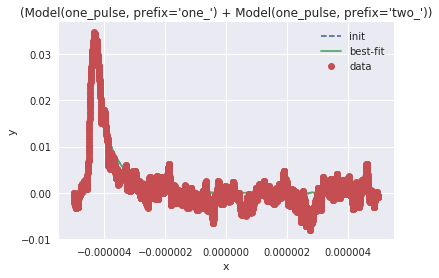

In [122]:
mask = np.minimum(one_amplitudes,two_amplitudes)>0.6
trace = '/home/jianwei_leejw/data/20161116_TES5_20MHz_bwl_diode_n012_height_optimised/continuous_diode/'+\
np.array(fnames)[mask&mcmc_flags&(taus_cont>0)&(taus_cont<20)][0]+'.trc'
np.array(results_formatted_cont)[mask&mcmc_flags&(taus_cont>0)&(taus_cont<20)][0].plot_fit()

caption: single photon pulses activates MCMC fitting since there is only one pulse region. Thus 0.5 amplitude pulses are overrepresented within MCMC fitted pulses.

In [148]:
np.sum([~mask&mcmc_flags&(taus_cont>0)&(taus_cont<20)])

17

In [109]:
def testcw(fname, sampling, burn, thin, height_th, Plot=True):
    result, mcmc_flag, unequal_edges = fit_two_cw(*hpa.trace_extr(fname, 
                                                  t_initial, t_final), 
                            
                                  height_th=height_th, 
                                  sampling=sampling,
                                 burn=burn,
                                 thin=thin,
                                debug=True)
    # pymc.gelman_rubin() #https://pymc-devs.github.io/pymc/modelchecking.html
    if Plot:
        plt.figure()
        plt.plot(*hpa.trace_extr(fname), label='unwindowed', color='grey')
        result.plot_fit()
        plt.savefig(results_directory+'testmcmccw.pdf')
        print result.fit_report()
        print ('arrival time difference = {:.2f}ns'.\
               format((result.init_values['one_x_offset']-result.init_values['two_x_offset'])*1e9))
    return result, mcmc_flag, unequal_edges

(-4.7800599153131698e-06, -3.9000599402012695e-06, None)
 [-----------------100%-----------------] 15000 of 15000 complete in 5.8 secPlotting two_x_amplitude
Plotting one_x_offset
Plotting one_x_amplitude
Plotting two_x_offset
[[Model]]
    (Model(one_pulse, prefix='one_') + Model(one_pulse, prefix='two_'))
[[Variables]]
    one_x_offset:   -4.5074e-06 +/- nan      (nan%) (init=-4.513963e-06)
    two_x_offset:   -4.5072e-06 +/- nan      (nan%) (init=-4.500213e-06)
    one_amplitude:   0.85888363 +/- 1.66e+04 (1935076.86%) (init= 0.824722)
    two_amplitude:   0.94526775 +/- 1.66e+04 (1758237.23%) (init= 0.9898061)
[[Correlations]] (unreported correlations are <  0.100)
    C(one_amplitude, two_amplitude)  = -1.000 

arrival time difference = -13.75ns


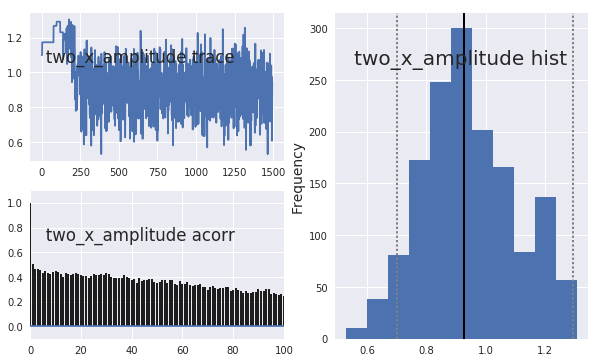

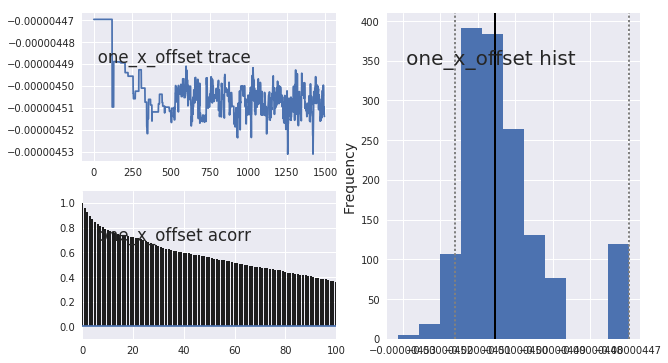

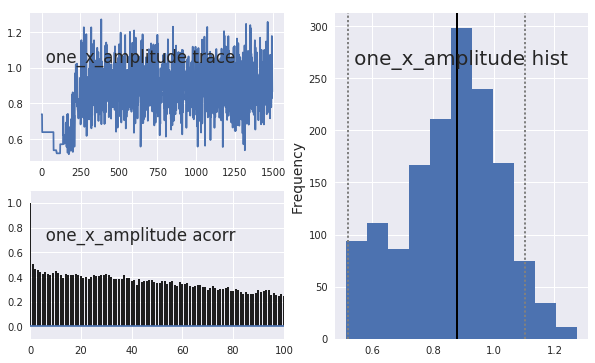

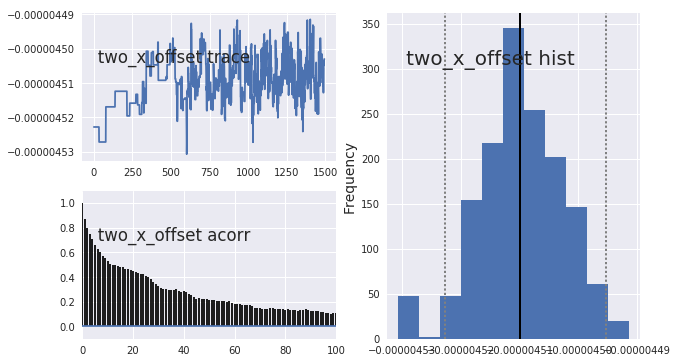

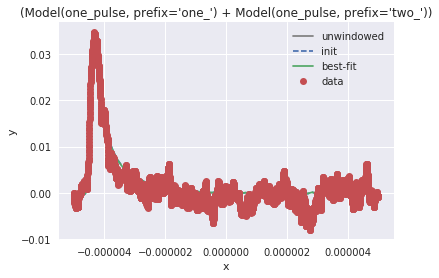

In [152]:
a, b, c = testcw(trace,sampling=1.5e4,burn=40,thin=10,
                height_th=height_th,Plot=True);

### Save a reduced version of the results

In [178]:
# Just extract the amplitudes and offsets from Bayesian or LMfit fits
keys = results_formatted_cont[0].init_values.keys()
dtype = [(key,'float') for key in keys]
results_cont_reduced =[tuple(np.array(r.init_values.values())) for r in results_formatted_cont]
results_cont_reduced = np.array(results_cont_reduced,dtype=dtype)
np.savetxt(results_directory+'results_cont_2nspp_reduced.dat',
           results_cont_reduced, header='\t'.join(results_cont_reduced.dtype.names))

### Load a reduced version of the results

In [ ]:
results = np.genfromtxt(results_directory+'results_cont_reduced.dat', names=True)
plt.figure()
plt.scatter(results['one_amplitude'],results['two_amplitude'])
plt.figure()
plt.hist(results['one_amplitude']-results['two_amplitude']/(results['one_amplitude']+results['two_amplitude']),100);

# Plotting Functions for troubleshooting

In [ ]:
plt.figure()
plt.plot(*hpa.trace_extr(filelist_cont[mask_2ph_cont][(abs_taus_cont>20)&(abs_taus_cont<50)][1]))
plt.xlim(0,2e-6)

In [ ]:
IntResult = np.array(results_cont)[(taus_cont>-60)&(taus_cont<-20)][3]
# IntResult = a #Interesting Result
time = hpa.trace_extr((filelist_cont[0]))[0]
time = time[time>=-2e-6]
signal = IntResult.data[time>=-2e-6]

plt.figure()
plt.xlim(0.2e-6,0.6e-6)
plt.plot(time, signal, label='data')

one_signal = one_pulse(time, IntResult.init_values['one_x_offset'], IntResult.init_values['one_amplitude'])
two_signal = one_pulse(time, IntResult.init_values['two_x_offset'], IntResult.init_values['two_amplitude'])

plt.plot(time,one_signal+two_signal,label='both pulses (mcmc)')
plt.plot(time,one_signal,label='first pulse (mcmc)')
plt.plot(time,two_signal,label='second pulse (mcmc)')
plt.legend()

plt.text(1.75e-6,0.03,IntResult.fit_report(),fontsize=5, va='top', ha='right')
plt.title('Bayesian fitted time difference = {:.2f}ns'\
    .format(np.abs(IntResult.init_values['one_x_offset']-IntResult.init_values['two_x_offset'])*1e9)
)

# Save plot, traces, report
# plt.savefig(results_directory + 'mcmc_fitted_components_cont.pdf')
# np.savetxt(results_directory+'mcmc_fitted_components_cont.dat',
#           zip(time,signal,one_signal,two_signal),
#           header="time\tsignal\tone_signal\ttwo_signal")
# with open("mcmc_fitted_components_cont.txt", "w") as text_file:
#     text_file.write("Purchase Amount: {0}".format(IntResult.fit_report()))

In [ ]:
# traces that fall between 0ns and _cont separation
plt.figure()
[plt.plot(r.data[::10], alpha=0.1) for r in np.array(results_cont)[(taus_cont>-60)&(taus_cont<-50)]];
plt.xlim(110,140)

In [ ]:
# traces that are correctly fitted for _cont separation
plt.figure()
[plt.plot(r.data[::10], alpha=0.1) for r in np.array(results_cont)[(taus_cont>-20)&(taus_cont<0)]];
plt.xlim(110,140)

In [ ]:
def testmcmc_bydata(time, signal, iters, height_th, Plot=True):
    result, result_mcmc = fit_two(time, signal, 
                                                  
                                  height_th=height_th, 
                                  sampling=iters)
    # pymc.gelman_rubin() #https://pymc-devs.github.io/pymc/modelchecking.html
    if Plot:
        plt.plot(time, signal, label='unwindowed')
        plt.plot(result_mcmc.time, result_mcmc.signal, 'b', marker='o', ls='-', lw=1, label='Observed')
        plt.plot(result_mcmc.time, result_mcmc.mod_two_pulse.value,'k', marker='+', ls='--', ms=5, mew=2, label='Bayesian Fit Values')
        plt.legend()
        print result.fit_report()
        print ('arrival time difference = {:.2f}ns'.\
               format((result.init_values['one_x_offset']-result.init_values['two_x_offset'])*1e9))
        pymc.Matplot.plot(result_mcmc)
    return result, result_mcmc

# a, b = testmcmc_bydata(time, signal,2e4,height_th,Plot=True)

# Load Pickle results

In [151]:
fileObject = open('lmfit_data_cont','r')
PickleObject=pickle.load(fileObject)

<IPython.core.display.Javascript object>


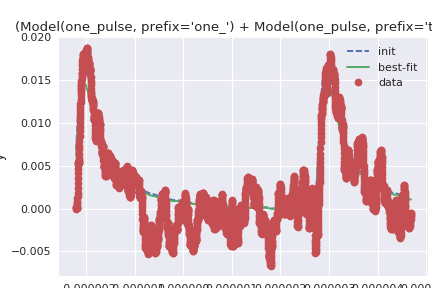

In [168]:
plt.figure()
PickleObject[315][0].plot_fit()

In [ ]:
results_formatted_cont